# An example of a standard adaptive learning approach for handling concept drift 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from river.tree import HoeffdingTreeClassifier
from streamselect.concept_representations import ErrorRateRepresentation
from streamselect.states import State
from streamselect.repository import Repository


First lets construct a dataset with concept drift.

Let us implement a simple 1d input x, with a threshold. Above the threshold y = 1, and below y = 0.
To represent abrupt concept drift, this threshold starts at 0.0 and changes to 1.0 halfway through the stream.

Text(0, 0.5, 'x')

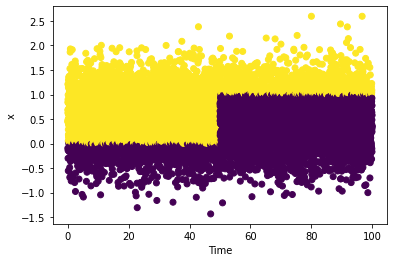

In [2]:
X = np.random.normal(0.5, 0.5, 10000)
T = np.linspace(0, 100, 10000)
Y = X > (0.25 * np.floor(T/50)*4)
plt.scatter(T, X, c=Y)
plt.xlabel("Time")
plt.ylabel("x")

Next, we implement a simple naive bayes classifier to attempt to learn the threshold.
Since the threshold changes, our learned threshold will become out-of-date- halfway through the stream.
This leads to accuracy falling substantially.

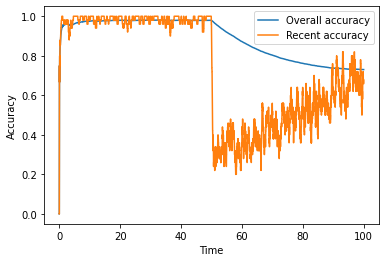

In [3]:
from river import naive_bayes
from river import stream
from river.metrics import Accuracy, Rolling

model = naive_bayes.GaussianNB()
acc = Accuracy()
rolling_acc = Rolling(Accuracy(), 50)
accuracy_over_time = []
rolling_accuracy_over_time = []
for x, y in stream.iter_array(X.reshape(-1, 1), Y):
    p = model.predict_one(x)
    _ = model.learn_one(x, y)
    acc.update(y, p)
    rolling_acc.update(y, p)
    accuracy_over_time.append(acc.get())
    rolling_accuracy_over_time.append(rolling_acc.get())

acc.get()

plt.plot(T, accuracy_over_time, label="Overall accuracy")
plt.plot(T, rolling_accuracy_over_time, label="Recent accuracy")
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.legend()

## Adaptive Learning

In the above example, our classifier encountered degraded accuracy because the *distribution* of data *changed* over time. This is known as concept drift. The basic idea of adaptive learning is to detect when concept drift has occured, and adapt the classifier to the new distribution. 

- 1) To detect concept drift, the overall idea is to *represent* the current concept, or distribution, on which our classifier is trained. If we also represent the distribution which recent data is drawn from, we could compare the two representations to get an idea of how well our classifier will handle incoming data. In other words, we can monitor the similarity between the two representations for concept drift.

- 2) When we detect concept drift, we need to adapt our classifier. In this case, we observe that old data before the concept drift is invalid, so we can discard it and build a new classifier.


### Representations

Let's first handle the representations. To do this, we define a simple data struction combining a classifier with some representation. We call this a *state*.
A standard representation is to use the error rate of the classifier. This representation is built on the idea that a classifier has learned to represent a given distribution of data, so it's error rate can be used to identify whether other data is behaving similarly or differently to the distribution it was trained on.

Lets first visualize the similarity between the current state and recent data.

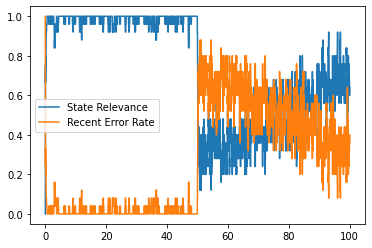

In [5]:
from streamselect.concept_representations import AbsoluteValueComparer

def construct_state(window_size=1, id=-1):
    """ Constructs a state, simply a classifier, representation pair.
    In this case, we use the GaussianNB classifier from before, and use
    the ErrorRate representation to keep track of the error rate on the 
    previous window_size observations. """
    return State(naive_bayes.GaussianNB(), ErrorRateRepresentation(window_size=window_size), state_id=id), id+1

# Initialize the first state to handle data
next_state_id = 0
curr_state, next_state_id = construct_state(id=next_state_id)

# Setup a repository to keep track of states
state_repository = Repository()
state_repository.add(curr_state)

# Finally, we need a comparer to calculate the similarity
# between the current state representation and a representation
# of recent data
sim = AbsoluteValueComparer()

def get_state_relevance(sim, state, recent_representation):
    """ The relevance of a state to recent data is given by
    the similarity between representations. """
    return sim.get_similarity(state.concept_representation, recent_representation)

recent_representation = ErrorRateRepresentation(25)
state_relevance = []
recent_representation_value = []

# In this case, we leave the representation of the state as default,
# by calling the classifier only cl_* methods of the state.
# The default error rate representation has a value of 0.0
# Implicitly, what this standard approach does is assume the current state
# perfectly represents the current concept.
# A drift is then detected when we have evidence against this hypothesis.
curr_state.deactivate_train_representation()

for x, y in stream.iter_array(X.reshape(-1, 1), Y):
    p = curr_state.predict_one(x)
    _ = curr_state.learn_one(x, y)

    # Update the representation of recent data
    recent_representation.learn_one(x, y, p)

    # The relevance of the current state represents the similarity between it's
    # representation and recent data.
    curr_state_relevance = get_state_relevance(sim, curr_state, recent_representation)

    # Saving results for plotting
    state_relevance.append(curr_state_relevance)
    recent_representation_value.append(recent_representation.values[0])

plt.plot(T, state_relevance, label="State Relevance")
plt.plot(T, recent_representation_value, label="Recent Error Rate")
plt.legend()

    



In this case, the relevance of the current state is directly the inverse of the error rate of the current state. This makes intuitive sense, if our classifier starts performing worse, it has become less relevant. This idea is formalized in the 'Probably Approximately Correct' (PAC) framework, which describes how the accuracy of a classifier should increase if it trains on more data from a stationary distribution.

We should detect this drop in relevance as concept drift.

(Note: Many approaches take a shortcut of directly monitoring classifier error rate. This directly corresponds to relevance when calculated as in this example, however in this library we provide a variety of more powerful relevance measures which are able to more accurately detect change in distribution. The approach we describe here can be directly ported to these other representations.)

In the code below, we use the ADWIN drift detector to detect a change in the relevance of the current classifier, which is plotted as a red line.

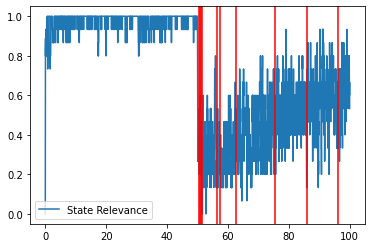

In [29]:
from river.drift import ADWIN

# Initialize the first state to handle data
next_state_id = 0
curr_state, next_state_id = construct_state(id=next_state_id)

# Setup a repository to keep track of states
state_repository = Repository()
state_repository.add(curr_state)

# Finally, we need a comparer to calculate the similarity
# between the current state representation and a representation
# of recent data
sim = AbsoluteValueComparer()

recent_representation = ErrorRateRepresentation(15)
state_relevance = []
detected_drifts = []

# In this case, we leave the representation of the state as default,
# by calling the classifier only cl_* methods of the state.
# The default error rate representation has a value of 0.0
# Implicitly, what this standard approach does is assume the current state
# perfectly represents the current concept.
# A drift is then detected when we have evidence against this hypothesis.
curr_state.deactivate_train_representation()

# initialize drift detector
drift_detector = ADWIN()

for t, (x, y) in enumerate(stream.iter_array(X.reshape(-1, 1), Y)):
    p = curr_state.predict_one(x)
    _ = curr_state.learn_one(x, y)

    # Update the representation of recent data
    recent_representation.learn_one(x, y, p)

    # The relevance of the current state represents the similarity between it's
    # representation and recent data.
    curr_state_relevance = get_state_relevance(sim, curr_state, recent_representation)

    # update drift detector
    # Some issues with typing, float -> Number
    in_drift, in_warning = drift_detector.update(curr_state_relevance) # type: ignore
    if in_drift and curr_state_relevance < drift_detector.estimation:
        detected_drifts.append(T[t])
    # Saving results for plotting
    state_relevance.append(curr_state_relevance)

plt.plot(T, state_relevance, label="State Relevance")
for t in detected_drifts:
    plt.axvline(t, c="red")
plt.legend()

We observe that the drift detector can successfully find timesteps where the relevance of the active state has fallen.

Now we just need to adapt to the drift. A simple method is to forget irrelevant experience by building a new state

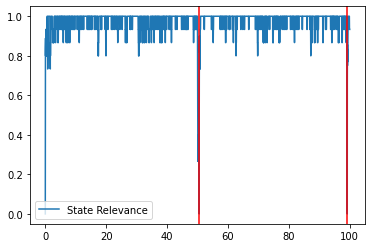

In [38]:
from river.drift import ADWIN

# Initialize the first state to handle data
next_state_id = 0
curr_state, next_state_id = construct_state(id=next_state_id)

# Setup a repository to keep track of states
state_repository = Repository()
state_repository.add(curr_state)

# Finally, we need a comparer to calculate the similarity
# between the current state representation and a representation
# of recent data
sim = AbsoluteValueComparer()

recent_representation = ErrorRateRepresentation(15)
state_relevance = []
detected_drifts = []

# In this case, we leave the representation of the state as default,
# by calling the classifier only cl_* methods of the state.
# The default error rate representation has a value of 0.0
# Implicitly, what this standard approach does is assume the current state
# perfectly represents the current concept.
# A drift is then detected when we have evidence against this hypothesis.
curr_state.deactivate_train_representation()

# initialize drift detector
drift_detector = ADWIN()

for t, (x, y) in enumerate(stream.iter_array(X.reshape(-1, 1), Y)):
    p = curr_state.predict_one(x)
    _ = curr_state.learn_one(x, y)

    # Update the representation of recent data
    recent_representation.learn_one(x, y, p)

    # The relevance of the current state represents the similarity between it's
    # representation and recent data.
    curr_state_relevance = get_state_relevance(sim, curr_state, recent_representation)

    # update drift detector
    # Some issues with typing, float -> Number
    in_drift, in_warning = drift_detector.update(curr_state_relevance) # type: ignore
    if in_drift and curr_state_relevance < drift_detector.estimation:
        detected_drifts.append(T[t])

        # Construct a new current state
        # Reset other statistics associated with the active state
        curr_state, next_state_id = construct_state(id=next_state_id)
        curr_state.deactivate_train_representation()
        state_repository.add(curr_state)
        drift_detector.reset()
        recent_representation = ErrorRateRepresentation(15)
        
    # Saving results for plotting
    state_relevance.append(curr_state_relevance)

plt.plot(T, state_relevance, label="State Relevance")
for t in detected_drifts:
    plt.axvline(t, c="red")
plt.legend()

We observe that we now are able to learn the new concept much more accurately.
This is because the new active state has forgotten the irrelevant experience from the previous concept.

Is constructing a new state the most effective form of adaptation?

It can be, if we have no previous experience relevant to the new concept. However, we often do have experience which is somewhat relevant. For example, a previous concept may have had similar fundamental patterns, or a concept may simply have reoccured. In the first case, research on transfer learning is investigating how we may transfer relevant patterns from similar experience in the past. 

In this library, we investigate fully recurring concepts. These are common in the real world, for example, recurring weather patterns or consumer behaviour. 
In these cases, we need to search our repository for a relevant state to reuse, rather than simply building a new one. We investigate this topic in other examples.